<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_NLP_Project/blob/main/%5BNLP_12%5DCreate_a_cool_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [NLP_12]Create a cool chatbot

## 1. Import 및 라이브러리 다운로드

In [1]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 29.5 MB/s 


In [2]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash


--2022-10-18 11:05:59--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-10-18 11:06:00--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7921d7d0fc6d98eadbc11f1893.dl.dropboxusercontent.com/cd/0/get/BvBI3w4HFdRFoH1JTeyyvaaNpakmznsIkRj7p35SAvQ-WxIS3HApyq5K2UU-vWIpgfRlDmBUoSNn1uPojbD0gk4GbjFiFKRbRQYC08uh797vBMJRj3B6viPdgvNdLB2m3G_Gm29eWLdm7gZHjR50gmremjAW3NPGY4boKIxuH7BV4vv7nJrZvOWZw-fhHA2U5_o/file?dl=1# [following]
--2022-10-18 11:06:01--  https://uc7921d7d0fc6d98eadbc11f1893.dl.dropboxusercontent.com/cd/0/get/BvBI3w4HFdR

In [50]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from konlpy.tag import Mecab

import re
import os
import random
import math
import urllib.request
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

mecab = Mecab()

## 2. 데이터 다운로드
준비하기 단계에서 심볼릭 링크를 생성했다면 아래 파일이 ChatbotData .csv라는 이름으로 저장되어 있을거예요. csv 파일을 읽는 데에는 pandas 라이브러리가 적합합니다. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장하세요!
- https://github.com/songys/Chatbot_data

- 일반 https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv 링크로는 오류가 생김 
- 이유는 웹 페이지 자체를 링크하기 때문임 그래서 raw를 선택하여 데이터만 있는 링크를 가지고 학습을 진행해야 함

In [26]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


- https://stackoverflow.com/questions/18039057/python-pandas-error-tokenizing-data

In [27]:
questions = []
answers = []
for i in range(len(train_data)):
  # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
  questions.append(str(train_data['Q'].values[i]))
  answers.append(str(train_data['A'].values[i]))

In [28]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [29]:
print(questions[100])
print(answers[100])

거지됐어
밥 사줄 친구를 찾아 보세요~


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 15
텍스트의 평균 길이 : 3.587414361837097
요약의 최소 길이 : 1
요약의 최대 길이 : 21
요약의 평균 길이 : 3.6936479742874058


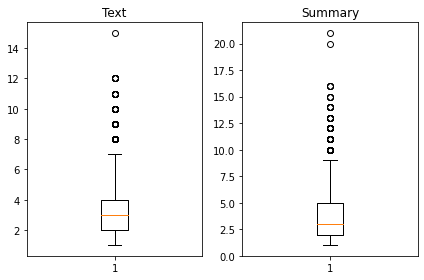

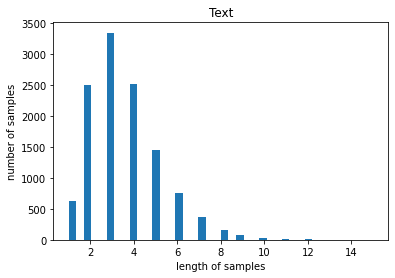

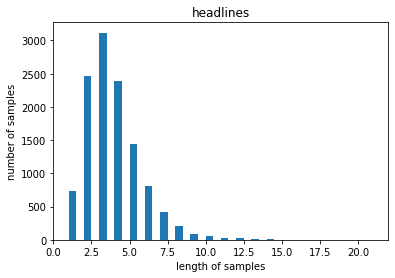

In [30]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in questions]
headlines_len = [len(s.split()) for s in answers]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
assert len(questions) == len(answers)

cleaned_corpus = list(set(zip(questions, answers)))

In [32]:
for pair in cleaned_corpus[:10]:
    print(pair)
    print('pair 0 :',pair[0])
    print('pair 1 :',pair[1])
    print(len(pair[0]))

('몸이 천근만근이다', '피로를 풀어야 할 것 같아요.')
pair 0 : 몸이 천근만근이다
pair 1 : 피로를 풀어야 할 것 같아요.
9
('제발 힘들면 기대줘', '그럴게요.')
pair 0 : 제발 힘들면 기대줘
pair 1 : 그럴게요.
10
('여친이랑 헤어진지 1년째인데 아직도 못잊네.', '언젠간 결정을 내려야하는 시기가 올 거예요.')
pair 0 : 여친이랑 헤어진지 1년째인데 아직도 못잊네.
pair 1 : 언젠간 결정을 내려야하는 시기가 올 거예요.
24
('헤어짐 통보 당한지 1달 정도 지났네', '후폭풍이 지나갔길 바랄게요.')
pair 0 : 헤어짐 통보 당한지 1달 정도 지났네
pair 1 : 후폭풍이 지나갔길 바랄게요.
20
('여자 어디서 만나', '소개팅 시켜달라고 말해보세요.')
pair 0 : 여자 어디서 만나
pair 1 : 소개팅 시켜달라고 말해보세요.
9
('기숙사 떨어졌어', '다음 학기에는 학점 관리를 더 열심히 해봐요.')
pair 0 : 기숙사 떨어졌어
pair 1 : 다음 학기에는 학점 관리를 더 열심히 해봐요.
8
('짝남한테 연락할까?', '연락해보세요.')
pair 0 : 짝남한테 연락할까?
pair 1 : 연락해보세요.
10
('나 맨날 속는 거 같아', '즐겁게 속아주세요.')
pair 0 : 나 맨날 속는 거 같아
pair 1 : 즐겁게 속아주세요.
12
('좋아하는 여자 생겼는데 호감 표시하려면 어떻게 해야 해?', '연락을 해보는게 좋아요.')
pair 0 : 좋아하는 여자 생겼는데 호감 표시하려면 어떻게 해야 해?
pair 1 : 연락을 해보는게 좋아요.
31
('헤어진지 어언 10개월', '많은 시간이 흘렀네요.')
pair 0 : 헤어진지 어언 10개월
pair 1 : 많은 시간이 흘렀네요.
12


## 3. 데이터 정제
아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요.

1. 영문자의 경우, 모두 소문자로 변환합니다.
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!

In [33]:
def preprocess_sentence(sentence):
  sentence = sentence.lower()
  sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  sentence = mecab.morphs(sentence)

  return sentence 

## 4. 데이터 토큰화
토큰화에는 KoNLPy의 mecab 클래스를 사용합니다.

아래 조건을 만족하는 build_corpus() 함수를 구현하세요!

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.

In [34]:
def build_corpus(cleaned_corpus):
  que_corpus = []
  ans_corpus = []
  for pair in cleaned_corpus:#[:num_examples]:
    que = preprocess_sentence(pair[0])
    ans = preprocess_sentence(pair[1])
    if len(que) <= 15  and len(ans) <= 15: 
      que_corpus.append(que)
      ans_corpus.append(ans)

  return que_corpus, ans_corpus

In [35]:
que_corpus, ans_corpus = build_corpus(cleaned_corpus)

In [36]:
print(que_corpus[0])
print(ans_corpus[0])

print(len(que_corpus))
print(len(ans_corpus))

['몸', '이', '천근만근', '이', '다']
['피로', '를', '풀', '어야', '할', '것', '같', '아요', '.']
10961
10961


## 5. Augmentation
우리에게 주어진 데이터는 1만 개가량으로 적은 편에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? Lexical Substitution을 실제로 적용해 보도록 하겠습니다.

아래 링크를 참고하여 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다. Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!

- https://github.com/Kyubyong/wordvectors

다운로드한 모델을 활용해 데이터를 Augmentation 하세요! 앞서 정의한 lexical_sub() 함수를 참고하면 도움이 많이 될 겁니다.

Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

- 참고 자료
  - https://github.com/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_8%5DAnalyzing_the_Sensibility_of_Film_Review_Texts.ipynb
  - https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-14%EC%9D%BC%EC%B0%A8-word2vec-%EC%8B%A4%EC%8A%B52-8e518a358b6c

In [37]:
word2vec_file_path_lstm = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_file_path_lstm)
ko_model.most_similar('사과')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('사죄', 0.5442899465560913),
 ('충고', 0.4946415424346924),
 ('질문', 0.48838865756988525),
 ('해명', 0.48268449306488037),
 ('대답', 0.4778830409049988),
 ('선처', 0.4665257930755615),
 ('질타', 0.4546084403991699),
 ('발언', 0.4542806148529053),
 ('회답', 0.45340797305107117),
 ('고소', 0.45193421840667725)]

In [38]:
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

- 이 부분때문에 조금 시간이 남비됨 문제가 생기면 print()로 찍어서 확인하며 해결하면 빠름
- type이 계속 None로 뜸 -> 런타임 초기화 체크하기

In [39]:
print(str(que_corpus[100]))
test = lexical_sub(que_corpus[100], ko_model)
print(type(test))
print(test.split())

['정장', '한', '벌', '필요', '할', '듯']
<class 'str'>
['정장', '한', '벌', '필요', '할', '듯하']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


In [40]:
def Augmentation_model(que_corpus , ans_corpus, ko_model):
    new_que_corpus = []
    new_ans_corpus = []

    for i in tqdm(range(len(que_corpus))):
        new_que = lexical_sub(que_corpus[i], ko_model)
        new_ans = lexical_sub(ans_corpus[i], ko_model)

        if new_que is not None: 
            new_que_corpus.append(new_que.split())
            new_ans_corpus.append(ans_corpus[i])
        
        if new_ans is not None:
            new_ans_corpus.append(new_ans.split())
            new_que_corpus.append(que_corpus[i])
          
    print(new_que_corpus[:100])
    print(new_ans_corpus[:100])

    return new_que_corpus, new_ans_corpus

In [41]:
new_que_corpus, new_ans_corpus = Augmentation_model(que_corpus , ans_corpus, ko_model)

  0%|          | 0/10961 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


[['몸', '이', '천근만근', '그러', '다'], ['몸', '이', '천근만근', '이', '다'], ['제발', '어렵', '면', '기대', '줘'], ['제발', '힘들', '면', '기대', '줘'], ['여친', '이랑', '헤어진지', '1', '년', '째이', '인데', '아직', '도', '못', '잊', '네', '.'], ['여친', '이랑', '헤어진지', '1', '년', '째', '인데', '아직', '도', '못', '잊', '네', '.'], ['헤어짐', '통보', '당한', '지', '1', '달', '정도', '지났', '네'], ['여자', '언제', '서', '만나'], ['여자', '어디', '서', '만나'], ['기숙사', '떨어졌', '어서'], ['기숙사', '떨어졌', '어'], ['짝', '남의', '한테', '연락', '할까', '?'], ['짝', '남', '한테', '연락', '할까', '?'], ['나', '맨날', '속', '는', '거', '같', '아'], ['좋', '아', '하', '는', '여자', '생겼', '는데', '호감', '표시', '하', '려면', '어떻게', '해야', '해의', '?'], ['좋', '아', '하', '는', '여자', '생겼', '는데', '호감', '표시', '하', '려면', '어떻게', '해야', '해', '?'], ['프로', '포즈', '곧', '넘겨받', '을', '거', '같', '은데'], ['프로', '포즈', '곧', '받', '을', '거', '같', '은데'], ['이', '길', '이', '나의', '에게', '맞', '는', '걸까'], ['이', '길', '이', '나', '에게', '맞', '는', '걸까'], ['재밌', 'ㄴ다는', '거', '할', '줄', '알', '아'], ['재밌', '는', '거', '할', '줄', '알', '아'], ['여자', '분', '들', '궁금', '해'], ['남자', '분', '

In [42]:
print(len(new_que_corpus))
print(len(new_ans_corpus))

18998
18998


In [43]:
que_corpus = que_corpus + new_que_corpus
ans_corpus = ans_corpus + new_ans_corpus

In [44]:
print(len(que_corpus))
print(len(ans_corpus))

29959
29959


## 6. 데이터 벡터화
타겟 데이터인 ans_corpus 에 <start> 토큰과 <end> 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 ans_corpus 는 list 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!

1. 위 소스를 참고하여 타겟 데이터 전체에 <start> 토큰과 <end> 토큰을 추가해 주세요!

챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것이겠죠. 앞서 배운 것처럼 이는 
 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

2. 특수 토큰을 더함으로써 ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 enc_train 과 dec_train 을 얻으세요!

In [45]:
temp_corpus = []
for sample_data in ans_corpus:
  temp_corpus.append(["<start>"] + sample_data + ["<end>"])

In [65]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=20 ,padding='post')

    return tensor, tokenizer

In [66]:
enc_train, enc_tokenizer  = tokenize(que_corpus)
dec_train, dec_tokenizer  = tokenize(temp_corpus)

In [84]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=BATCH_SIZE)

In [85]:
enc_train, enc_test, dec_train, dec_test = \
train_test_split(enc_train, dec_train, test_size=0.2)

enc_train_size = len(enc_train)
dec_train_size = len(dec_train)
enc_test_size = len(enc_test)
dec_test_size = len(dec_test)
print("한국어 train Size:", enc_train_size)
print("영어 train Size:", dec_train_size)
print("한국어 test Size:", enc_test_size)
print("영어 test Size:", dec_test_size)
print('한국어 shape : ', enc_train.shape)
print('영어 shape : ', dec_train.shape)

한국어 train Size: 19173
영어 train Size: 19173
한국어 test Size: 4794
영어 test Size: 4794
한국어 shape :  (19173, 20)
영어 shape :  (19173, 20)


## 7. 훈련하기
앞서 번역 모델을 훈련하며 정의한 Transformer 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! 가장 멋진 답변과 모델의 하이퍼파라미터를 제출하시면 됩니다.

In [86]:

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [87]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [88]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [89]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [90]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [91]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [92]:

class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [93]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [94]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [95]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=enc_train_size,
    tgt_vocab_size=dec_train_size,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512

In [96]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [97]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)


In [98]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [99]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [100]:
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

In [109]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [110]:
def translate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))



In [111]:
examples = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

In [112]:
for example in examples:
    translate(example, transformer)


TypeError: ignored

## 8. 성능 측정하기
챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표입니다. 올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 calculate_bleu() 함수도 적용해 보세요.